## Project: Finding signals in financial markets

### Objective
- Develop a signal (or a combination of signals) applicable to financial markets or a specific one.

### Requirements

#### 1. Signal Development
- Choose a single signal or combine set of signals (e.g., PCA).
- **Economic Reasoning:** Try to explain why the signal works (or does not work) based on market behavior (trend-following, mean-reversion, volatility, etc.).

#### 2. Testing
- Test the signal on **5 different time series** with varying timeframes
- Use different instruments (stocks, bonds, indices, fx spot currencies, futures)
- Daily, Monthly, 1-hour, 15-minute. It can be 5 different daily time series from different markets. It can be 5 different time series with different frequencies from 5 different markets. 
- Try to find some patterns for markets (stock + index vs bond, fx spot)
- Use long enough datasets for robust results

#### 3. Performance Evaluation
- Use multiple performance metrics
- Try to measure performance by analysing return rates assuming one signal at the time (if buy signal then wait for sell signal). 
  - Sharpe Ratio, Maximum Drawdown, Win Rate, etc.

#### 4. Implementation
- **Language:** Python (or preferred language).
- Code and results should be shared via a public GitHub repository with me (via email).
- Keep the Github history - I would like to see the individual contribution if you work in pairs

#### 5. Presentation (5 minutes) per person/team
- Share the signal idea, economic reasoning, and test results.
- Discuss whether the signal was effective across different timeframes and markets.
- If somebody cannot attend the lecture please leave me a note and we will find some time during the evening for the presentation on Zoom

##### 6. Grade
- Can be done in pairs (let me know in advance - for better planning the next lecture) 
- Code
- Presentation
- Idea behind the research
- Meeting the deadline - the next lecture

##### Datasource
- Yahoo finance (used during the lecture)
- Ducascopy (tick data) https://github.com/algogenetic/dukascopy-1
- Intrinio https://intrinio.com - price, company financials
- Quandl https://www.quandl.com/tools/python

##### Best books - min effort max outcome for this assignments
- Python for algorithmic trading - Yves Hilpisch
- Economic Indicator Handbook - Yamarone Richard
- Evidence-Based Technical Analysis: Applying the Scientific Method and Statistical Inference to Trading Signals - David Aronson

In [35]:
import yfinance as yf
import pandas as pd
import numpy as np
import plotly.graph_objs as go
import matplotlib.pyplot as plt

def create_ma(data):
  df = data.copy()
  # Calculate 50-period and 100-period moving averages
  df['50ma'] = df['Adj Close'].rolling(window=50).mean().values
  df['100ma'] = df['Adj Close'].rolling(window=100).mean().values

  # Create a column to track the difference between 50ma and 100ma
  df['ma_diff'] = df['50ma'] - df['100ma']

  # Detect crossing points
  df['SignalMA'] = np.where(df['ma_diff'] > 0, 1, 0)  # 1 when 50ma > 100ma, 0 otherwise
  df['CrossoverMA'] = df['SignalMA'].diff()  # Detect where crossovers happen (1 -> buy signal, -1 -> sell signal)
  return df


def visualiza_ma(data, index_name):
  # Identify buy and sell signal dates
  buy_signals = data[data['CrossoverMA'] == 1].index
  sell_signals = data[data['CrossoverMA'] == -1].index

  # Plot the data with signals
  plt.figure(figsize=(14, 7))
  plt.plot(data['Adj Close'], label='Adjusted Close Price', color='blue', alpha=0.5)
  plt.plot(data['50ma'], label='50-Day Moving Average', color='green', alpha=0.75)
  plt.plot(data['100ma'], label='100-Day Moving Average', color='red', alpha=0.75)
  plt.scatter(buy_signals, data.loc[buy_signals]['Adj Close'], marker='^', color='green', label='Buy Signal', alpha=1)
  plt.scatter(sell_signals, data.loc[sell_signals]['Adj Close'], marker='v', color='red', label='Sell Signal', alpha=1)
  plt.title(f'{index_name} Price and Moving Averages with Buy/Sell Signals')
  plt.xlabel('Date')
  plt.ylabel('Price (USD)')
  plt.legend()
  plt.show()

def create_RSI(data, window_length = 14):
  df = data.copy()
  # RSI calculation (Relative Strength Index)
  window_length = 14 # 14-day period for RSI
  delta = df['Adj Close'].diff(1)  # Calculate the difference in price
  gain = delta.where(delta > 0, 0)  # Only positive gains
  loss = -delta.where(delta < 0, 0)  # Only negative losses

  # Calculate the rolling averages of gain and loss
  avg_gain = gain.rolling(window=window_length).mean()
  avg_loss = loss.rolling(window=window_length).mean()

  # Calculate RSI
  rs = avg_gain / avg_loss
  df['RSI'] = 100 - (100 / (1 + rs))  # The RSI formula

  # Initialize columns for signals
  df['Buy Signal'] = 0
  df['Sell Signal'] = 0
  
  # Generate buy/sell signals based on RSI crossover
  for i in range(1, len(df)):
      # Buy signal when RSI crosses 30 from below
      if df['RSI'].iloc[i] > 30 and df['RSI'].iloc[i-1] <= 30:
          df.loc[df.index[i], 'Buy Signal'] = 1  # Use .loc for assignment
      # Sell signal when RSI crosses 70 from above
      elif df['RSI'].iloc[i] < 70 and df['RSI'].iloc[i-1] >= 70:
          df.loc[df.index[i], 'Sell Signal'] = 1  # Use .loc for assignment

  return df

def visualize_RSI(data, index_name):
    # Create a figure
    plt.figure(figsize=(14, 7))

    # Plot the stock price
    plt.plot(data.index, data['Adj Close'], label='Adjusted Close Price', color='blue', alpha=0.7)

    # Add buy signals to the chart
    buy_signals = data[data['Buy Signal'] == 1].index
    plt.scatter(buy_signals, data.loc[buy_signals, 'Adj Close'], 
                marker='^', color='green', label='Buy Signal (RSI crosses 30)', alpha=1, s=100)

    # Add sell signals to the chart
    sell_signals = data[data['Sell Signal'] == 1].index
    plt.scatter(sell_signals, data.loc[sell_signals, 'Adj Close'], 
                marker='v', color='red', label='Sell Signal (RSI crosses 70)', alpha=1, s=100)

    # Customize the layout
    plt.title(f'{index_name} Price with RSI Buy/Sell Signals', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Price (USD)', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(alpha=0.3)
    plt.xticks(rotation=45)  # Rotate x-axis labels if needed for better readability

    # Show the chart
    plt.show()

    # Create a separate figure for the RSI
    fig2 = go.Figure()

    # Plot the RSI
    fig2.add_trace(go.Scatter(
        x=data.index,
        y=data['RSI'],
        mode='lines',
        name='RSI (14-period)',
        line=dict(color='blue')
    ))

    # Plot overbought (>70) and oversold (<30) regions
    fig2.add_hline(y=70, line=dict(color='red', dash='dash'), annotation_text="Overbought", 
                    annotation_position="top right")
    fig2.add_hline(y=30, line=dict(color='green', dash='dash'), annotation_text="Oversold", 
                    annotation_position="bottom right")

    # Add buy signals when RSI crosses above 30
    fig2.add_trace(go.Scatter(
        x=buy_signals,
        y=data.loc[buy_signals, 'RSI'],
        mode='markers',
        name='Buy Signal (RSI crosses 30)',
        marker=dict(color='green', symbol='triangle-up', size=10)
    ))

    # Add sell signals when RSI crosses below 70
    fig2.add_trace(go.Scatter(
        x=sell_signals,
        y=data.loc[sell_signals, 'RSI'],
        mode='markers',
        name='Sell Signal (RSI crosses 70)',
        marker=dict(color='red', symbol='triangle-down', size=10)
    ))

    # Customize the layout for the RSI chart
    fig2.update_layout(
        title="RSI (14-period) with Crossover Buy/Sell Signals",
        xaxis_title="Date",
        yaxis_title="RSI Value",
        xaxis_rangeslider_visible=False
    )


    fig2.show()  # RSI chart


def create_MACD(data):
    df = data.copy()
    # Calculate MACD and Signal Line
    short_ema = df['Adj Close'].ewm(span=12, adjust=False).mean()  # 12-period EMA
    long_ema = df['Adj Close'].ewm(span=26, adjust=False).mean()  # 26-period EMA
    df['MACD'] = short_ema - long_ema  # MACD Line
    df['Signal Line'] = df['MACD'].ewm(span=9, adjust=False).mean()  # Signal Line

    # Generate buy and sell signals based on MACD crossover
    df['Buy SignalMACD'] = 0
    df['Sell SignalMACD'] = 0

    for i in range(1, len(data)):
        # Buy signal: MACD crosses above Signal Line
        if df['MACD'].iloc[i] > df['Signal Line'].iloc[i] and df['MACD'].iloc[i-1] <= df['Signal Line'].iloc[i-1]:
            df.loc[data.index[i], 'Buy SignalMACD'] = 1
        # Sell signal: MACD crosses below Signal Line
        elif df['MACD'].iloc[i] < df['Signal Line'].iloc[i] and df['MACD'].iloc[i-1] >= df['Signal Line'].iloc[i-1]:
            df.loc[df.index[i], 'Sell SignalMACD'] = 1
    return df

def visualize_MACD(data, index_name):

    # Create a figure
    plt.figure(figsize=(14, 7))

    # Plot the stock price
    plt.plot(data.index, data['Adj Close'], label='Adjusted Close Price', color='blue', alpha=0.7)

    # Add buy signals to the chart
    buy_signals = data[data['Buy SignalMACD'] == 1].index
    plt.scatter(buy_signals, data.loc[buy_signals, 'Adj Close'], 
                marker='^', color='green', label='Buy Signal (RSI crosses 30)', alpha=1, s=100)

    # Add sell signals to the chart
    sell_signals = data[data['Sell SignalMACD'] == 1].index
    plt.scatter(sell_signals, data.loc[sell_signals, 'Adj Close'], 
                marker='v', color='red', label='Sell Signal (RSI crosses 70)', alpha=1, s=100)

    # Customize the layout
    plt.title(f'{index_name} Price with RSI Buy/Sell Signals', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Price (USD)', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(alpha=0.3)
    plt.xticks(rotation=45)  # Rotate x-axis labels if needed for better readability

    # Show the chart
    plt.show()
    # Create a second plot for MACD and Signal Line
    fig2 = go.Figure()


    buy_signals = data[data['Buy SignalMACD'] == 1].index
    sell_signals = data[data['Sell SignalMACD'] == 1].index

    # Plot MACD Line
    fig2.add_trace(go.Scatter(
        x=data.index,
        y=data['MACD'],
        mode='lines',
        name='MACD Line',
        line=dict(color='blue')
    ))

    # Plot Signal Line
    fig2.add_trace(go.Scatter(
        x=data.index,
        y=data['Signal Line'],
        mode='lines',
        name='Signal Line',
        line=dict(color='orange')
    ))

    # Add buy signals to the MACD chart
    fig2.add_trace(go.Scatter(
        x=buy_signals,
        y=data.loc[buy_signals, 'MACD'],
        mode='markers',
        name='Buy Signal (MACD)',
        marker=dict(color='green', symbol='triangle-up', size=10)
    ))

    # Add sell signals to the MACD chart
    fig2.add_trace(go.Scatter(
        x=sell_signals,
        y=data.loc[sell_signals, 'MACD'],
        mode='markers',
        name='Sell Signal (MACD)',
        marker=dict(color='red', symbol='triangle-down', size=10)
    ))

    # Customize the layout for the MACD chart
    fig2.update_layout(
        title="MACD and Signal Line with Crossover Buy/Sell Signals",
        xaxis_title="Date",
        yaxis_title="MACD",
        xaxis_rangeslider_visible=False
    )

    fig2.show()  # MACD chart with buy/sell signals

In [ ]:
#the macd function was create second time to create a simpler version as this is the only component we need for the model, as buy and sell signal will be developed later
def calculate_macd(data,fast = 12, slow = 26, signal = 2):
    """
    Calculate MACD and Signal Line.
    """
    data['MACD'] = data['Adj Close'].ewm(span=fast, adjust=False).mean() - data['Adj Close'].ewm(span=slow, adjust=False).mean()
    data['Signal_Line'] = data['MACD'].ewm(span=signal, adjust=False).mean()
    return data

In [3]:
def calculate_stochastic(df, kp=14, dp = 3):
    """
    Calculate Stochastic Oscillator (%K and %D).
    """
    # Define periods
    k_period = kp
    d_period = dp
    # Adds a "n_high" column with max value of previous 14 periods
    df['n_high'] = df['High'].rolling(k_period).max()
    # Adds an "n_low" column with min value of previous 14 periods
    df['n_low'] = df['Low'].rolling(k_period).min()
    # Uses the min/max values to calculate the %k (as a percentage)
    df['%K'] = (df['Close'] - df['n_low']) * 100 / (df['n_high'] - df['n_low'])
    # Uses the %k to calculates a SMA over the past 3 values of %k
    df['%D'] = df['%K'].rolling(d_period).mean()
    return df

In [4]:
def download_data(ticker, start= "2014-01-01", end= "2024-01-01", interval = "1d"):
    data = yf.download(ticker, start=start, end=end, interval=interval)
    data.columns = ["Adj Close", "Close", "High", "Low", "Open", "Volume"]
    return data

In [5]:
import matplotlib.pyplot as plt
def plot_strategy(data,ticker):
    # Plot buy/sell signals
    plt.figure(figsize=(14, 7))
    plt.plot(data['Adj Close'], label='Adjusted Close', color='blue', alpha=0.5)
    plt.scatter(data.index[data['Buy']], data['Adj Close'][data['Buy']], color='green', marker='^', label='Buy Signal')
    plt.scatter(data.index[data['Sell']], data['Adj Close'][data['Sell']], color='red', marker='v', label='Sell Signal')
    plt.title(f"{ticker} - MACD + Stochastic Signals")
    plt.xlabel("Date")
    plt.ylabel("Price (USD)")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

In [6]:
def macd_stoch_signals(data, oversold = 30, overbought = 70):
    """
    Combine MACD and Stochastic Oscillator for buy/sell signals.
    """
    # Calculate indicators
    data = calculate_stochastic(calculate_macd(data))
    

    # Define buy and sell logic
    data['Buy'] = (
        (data['MACD'] > data['Signal_Line']) &    # MACD bullish crossover
        (data['%K'] > data['%D']) &              # Stochastic bullish crossover
        (data['%K'] < oversold)                        # Oversold condition
    )
    data['Sell'] = (
        (data['MACD'] < data['Signal_Line']) &    # MACD bearish crossover
        (data['%K'] < data['%D']) &              # Stochastic bearish crossover
        (data['%K'] > overbought)                        # Overbought condition
    )

    return data


[*********************100%***********************]  1 of 1 completed


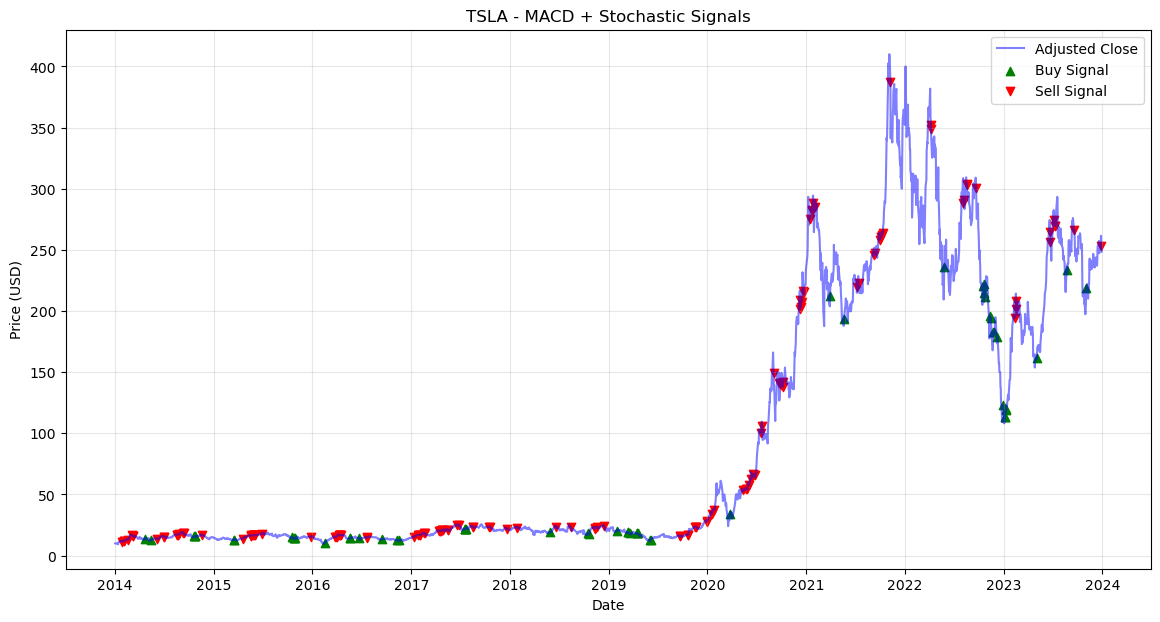

In [7]:
ticker = "TSLA"
data = download_data(ticker)

data_changed = macd_stoch_signals(calculate_stochastic(calculate_macd(data)),40,60)
plot_strategy(data_changed,ticker)

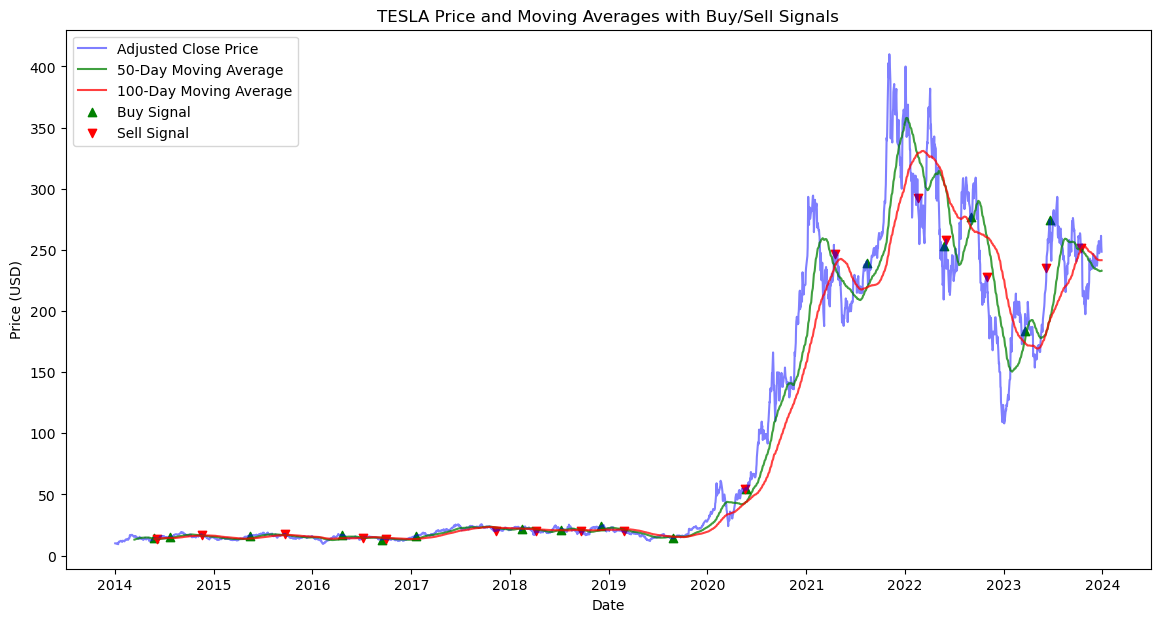

In [33]:
visualiza_ma(create_ma(data), "TESLA")

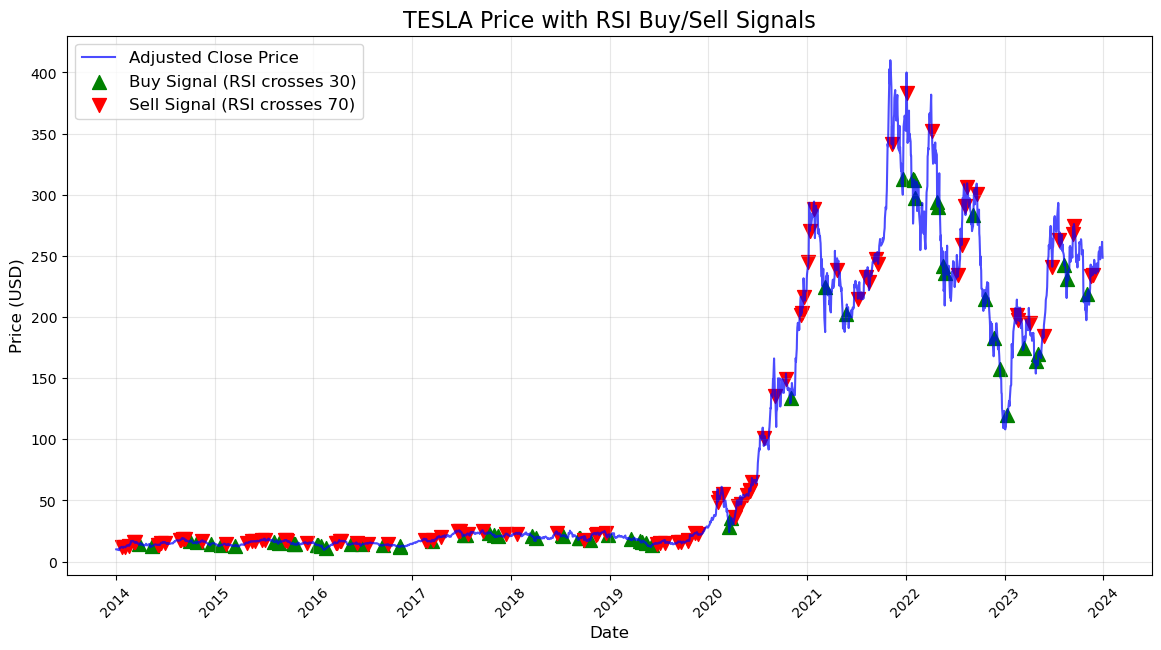

In [36]:

visualize_RSI(create_RSI(data),"TESLA")

In [8]:
# Backtesting Function
def backtest_single_position(data, initial_balance=10000):
    balance = initial_balance
    in_position = False
    entry_price = data["Close"].iloc[0]
    balance_history = []
    trades = []
    trades_ix = []

    for index, row in data.iterrows():
        if row['Buy'] and not in_position:  # Buy signal
            in_position = True
            entry_price = row['Close']
            trades_ix.append((index, 'Buy'))  # Append buy signal
        elif row['Sell'] and in_position:  # Sell signal
            in_position = False
            profit = (row['Close'] - entry_price) / entry_price * balance
            balance += profit
            trades.append(profit)
            trades_ix.append((index, 'Sell'))  # Append sell signal
        balance_history.append(balance)
    # Add results to DataFrame
    #data['Balance'] = balance_history

    return balance_history, trades, trades_ix

In [9]:
def plot_balance(data, balance_history, trades_ix):
    plt.figure(figsize=(14, 7))

    # Plot balance history as a line
    plt.plot(data.index, balance_history, label='Balance', color='blue', alpha=0.7)

    # Mark trades
    for trade_ix, trade_type in trades_ix:
        color = 'green' if trade_type == 'Buy' else 'red'
        plt.scatter(trade_ix, balance_history[data.index.get_loc(trade_ix)], color=color, s=50, label=f'{trade_type} Trade')

    # Add labels and legend
    plt.title("Balance Over Time with Trades")
    plt.xlabel("Date")
    plt.ylabel("Balance (USD)")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()


In [10]:
balance, trades, trades_ix = backtest_single_position(data_changed)

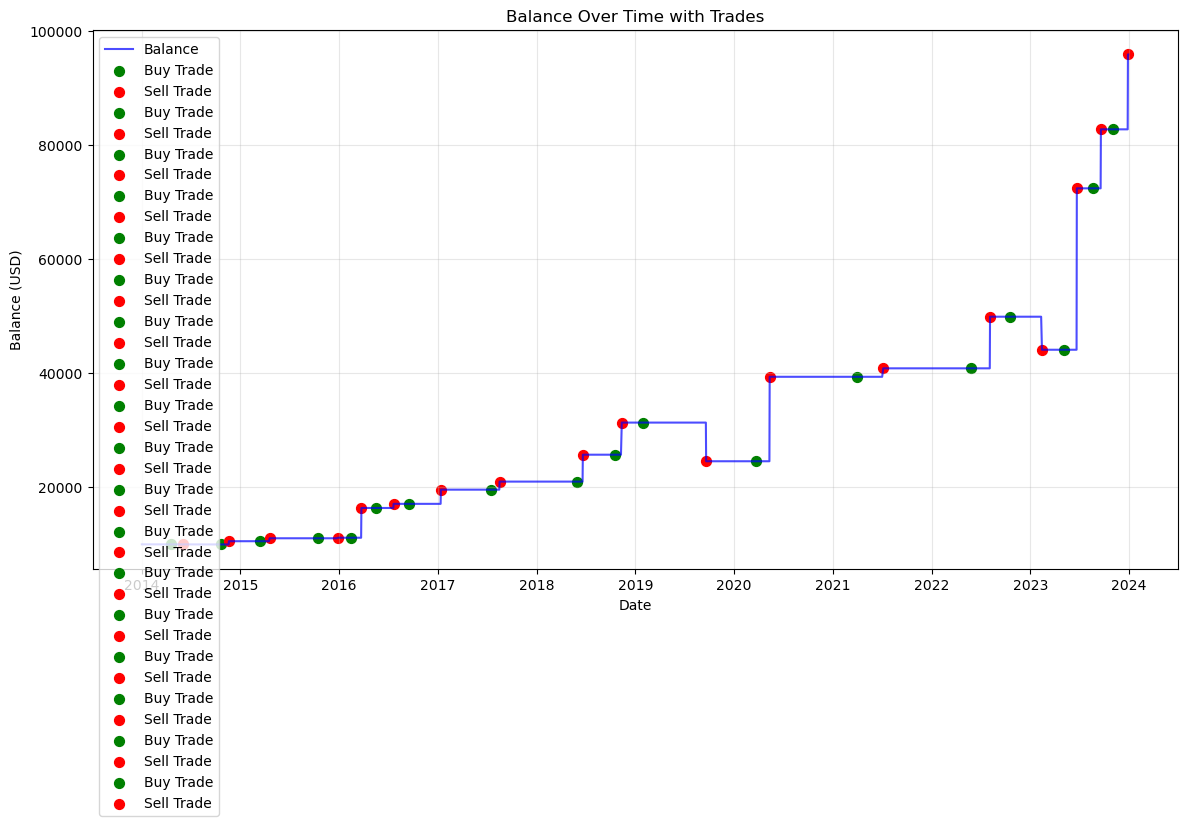

In [11]:
plot_balance(data_changed, balance, trades_ix)

In [12]:
def evaluate_strategy_single_position(balance_history, trades, initial_balance=10000):
    if not trades:  # No trades executed
        return {
            'Total Return (%)': 0,
            'Win Rate (%)': 0,
            'Profit Factor': 0,
            'Max Drawdown (%)': 0,
            'Sharpe Ratio': 0
        }

    # Total Return
    total_return = (balance_history[-1] - initial_balance) / initial_balance * 100

    # Win Rate
    win_rate = len([t for t in trades if t > 0]) / len(trades) * 100

    # Profit Factor
    if any(t < 0 for t in trades):  # Check for losing trades
        total_gains = sum([t for t in trades if t > 0])
        total_losses = abs(sum([t for t in trades if t < 0]))
        profit_factor = total_gains / total_losses
    else:
        profit_factor = "All Profitable"  # No losing trades

    # Max Drawdown
    peak_balance = initial_balance
    max_drawdown = 0
    for balance in balance_history:
        peak_balance = max(peak_balance, balance)
        drawdown = (peak_balance - balance) / peak_balance * 100
        max_drawdown = max(max_drawdown, drawdown)

    # Sharpe Ratio
    trade_returns = [t / initial_balance for t in trades]  # Trade returns as percentages
    if len(trade_returns) > 1:
        sharpe_ratio = np.mean(trade_returns) / np.std(trade_returns) * np.sqrt(len(trade_returns))
    else:
        sharpe_ratio = 0

    return {
        'Total Return (%)': total_return,
        'Win Rate (%)': win_rate,
        'Profit Factor': profit_factor,
        'Max Drawdown (%)': max_drawdown,
        'Sharpe Ratio': sharpe_ratio
    }


In [13]:
trades

[-19.08211946682054,
 567.0309124284599,
 515.8088552350358,
 94.54965462973725,
 5219.241902460835,
 723.5993257335117,
 2488.9759969423294,
 1413.2755781649018,
 4718.659210901423,
 5631.252890723957,
 -6780.863117550673,
 14812.076183364241,
 1484.6179692467374,
 9053.544961328887,
 -5792.837194355454,
 28309.35153570486,
 10347.569083898092,
 13135.404754742487]

In [14]:
evaluation = evaluate_strategy_single_position(balance,trades)

evaluation

{'Total Return (%)': 859.2217638413256,
 'Win Rate (%)': 83.33333333333334,
 'Profit Factor': 7.823128792416114,
 'Max Drawdown (%)': 21.627262448762373,
 'Sharpe Ratio': 2.5397648484268047}

In [15]:
result = pd.DataFrame([evaluation])
result["type"] = f"Stock {ticker}"
result

,Total Return (%),Win Rate (%),Profit Factor,Max Drawdown (%),Sharpe Ratio,type
0,859.221764,83.333333,7.823129,21.627262,2.539765,Stock TSLA


<h1> GOLD

[*********************100%***********************]  1 of 1 completed


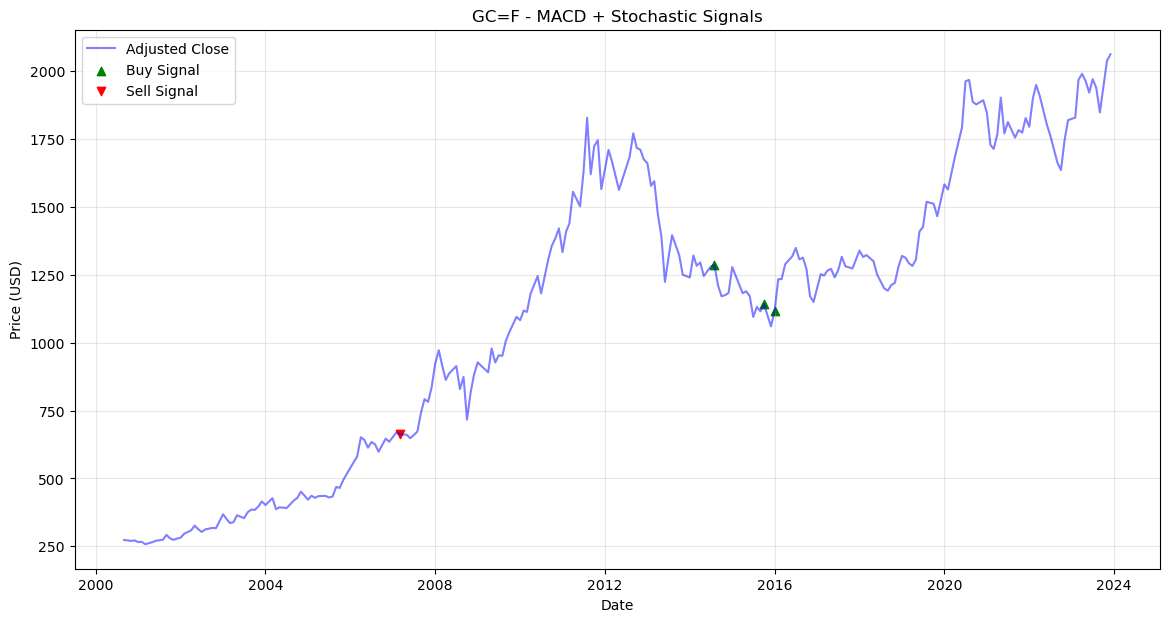

In [16]:
#gold monthly for the last 50 years
ticker_gold = "GC=F"  # Gold Futures
data_gold = download_data(ticker_gold, "1973-01-01", "2023-12-31", "1mo")
data_gold_changed = macd_stoch_signals(calculate_stochastic(calculate_macd(data_gold), 45, 55))
plot_strategy(data_gold_changed, ticker_gold)


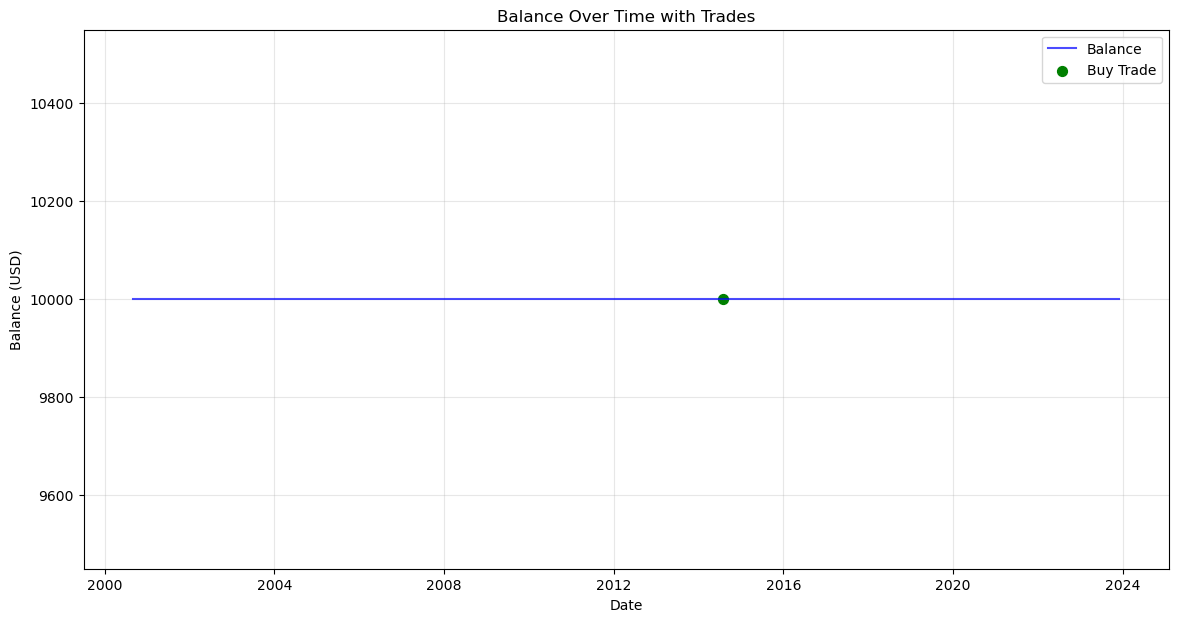

In [17]:
balance_gold, trades_gold, trades_ix_gold = backtest_single_position(data_gold_changed)
plot_balance(data_gold_changed, balance_gold, trades_ix_gold)

In [18]:
evaluation_gold = evaluate_strategy_single_position(balance_gold, trades_gold)
evaluation_gold["type"] = "Gold"
results = pd.concat([result, pd.DataFrame([evaluation_gold])], ignore_index=True)
results

,Total Return (%),Win Rate (%),Profit Factor,Max Drawdown (%),Sharpe Ratio,type
0,859.221764,83.333333,7.823129,21.627262,2.539765,Stock TSLA
1,0.000000,0.000000,0.000000,0.000000,0.000000,Gold


results are not good for this so lets twist the paramateres for stochastic and MADC

[*********************100%***********************]  1 of 1 completed

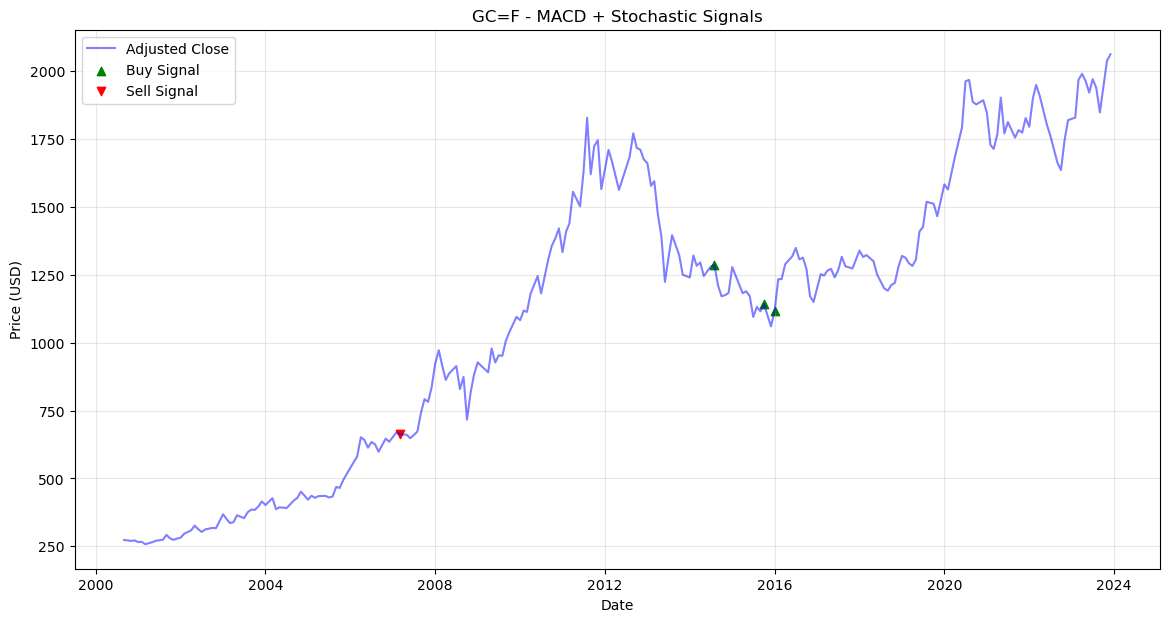

In [19]:
ticker_gold = "GC=F"
data_gold = download_data(ticker_gold, "1973-01-01", "2023-12-31", "1mo")

# Apply adjusted MACD and Stochastic
data_gold_changed = macd_stoch_signals(calculate_stochastic(calculate_macd(data_gold, fast=6, slow=18, signal=4), kp=9, dp=5))
plot_strategy(data_gold_changed, ticker_gold)

[*********************100%***********************]  1 of 1 completed


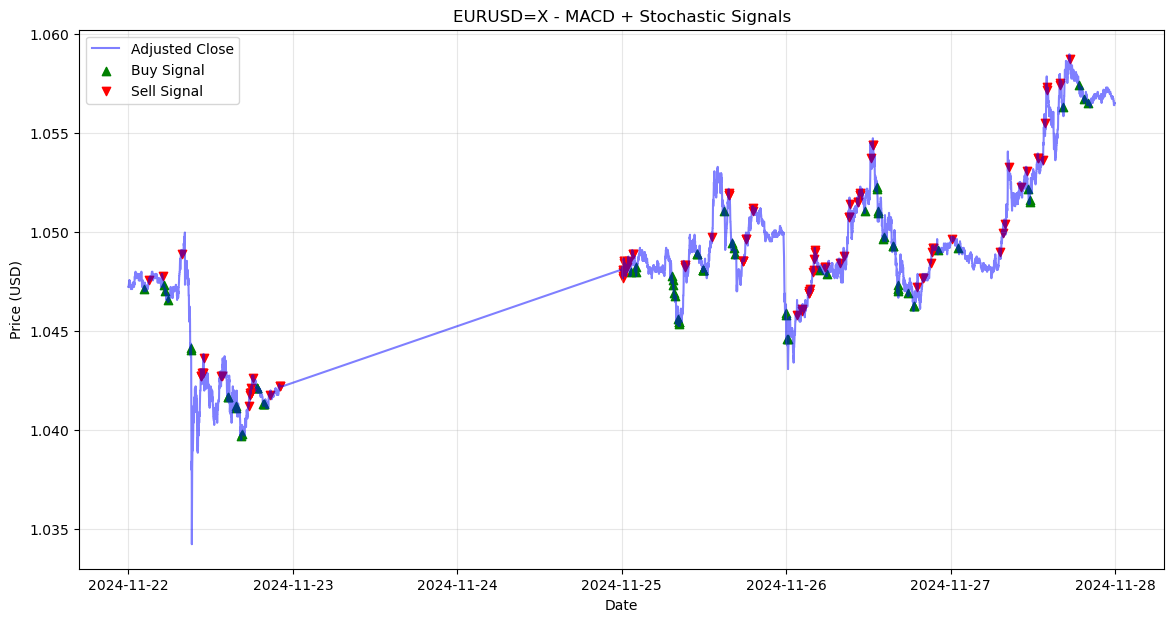

In [20]:
#euro PLN 15 - minute if u can if not 1 minute period for last 3 months 
ticker_eurpln = "EURUSD=X"  # Euro to PLN
data_eurpln = download_data(ticker_eurpln, "2024-11-22", "2024-11-28", "1m")
data_eurpln_changed = macd_stoch_signals(calculate_stochastic(calculate_macd(data_eurpln), 40, 60))
plot_strategy(data_eurpln_changed, ticker_eurpln)

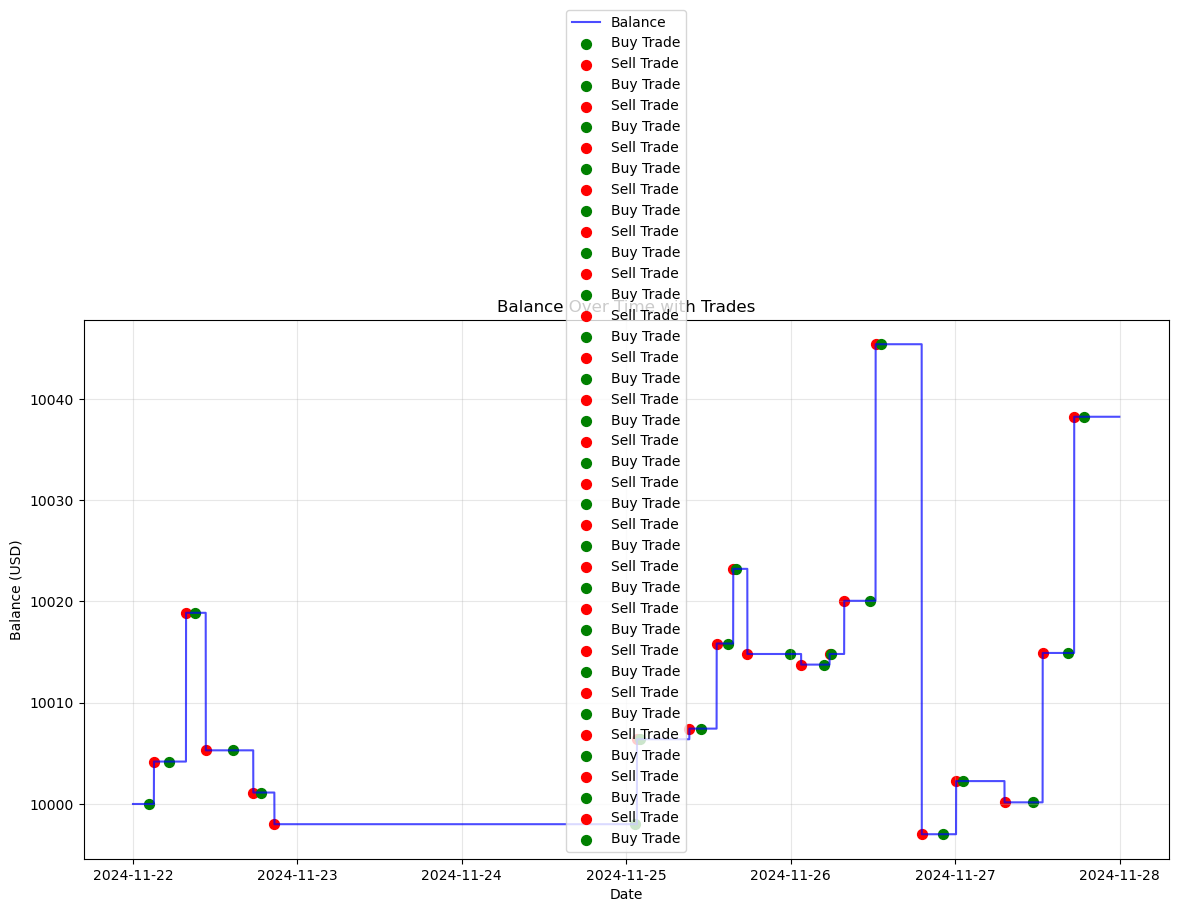

In [21]:
balance_eurpln, trades_eurpln, trades_ix_eurpln = backtest_single_position(data_eurpln_changed)
plot_balance(data_eurpln_changed, balance_eurpln, trades_ix_eurpln)

In [22]:
evaluation_eurpln = evaluate_strategy_single_position(balance_eurpln, trades_eurpln)
evaluation_eurpln["type"] = "Euro to PLN"
results = pd.concat([results, pd.DataFrame([evaluation_eurpln])], ignore_index=True)
results

,Total Return (%),Win Rate (%),Profit Factor,Max Drawdown (%),Sharpe Ratio,type
0,859.221764,83.333333,7.823129,21.627262,2.539765,Stock TSLA
1,0.000000,0.000000,0.000000,0.000000,0.000000,Gold
2,0.382428,63.157895,1.473172,0.481731,0.573763,Euro to PLN


[*********************100%***********************]  1 of 1 completed


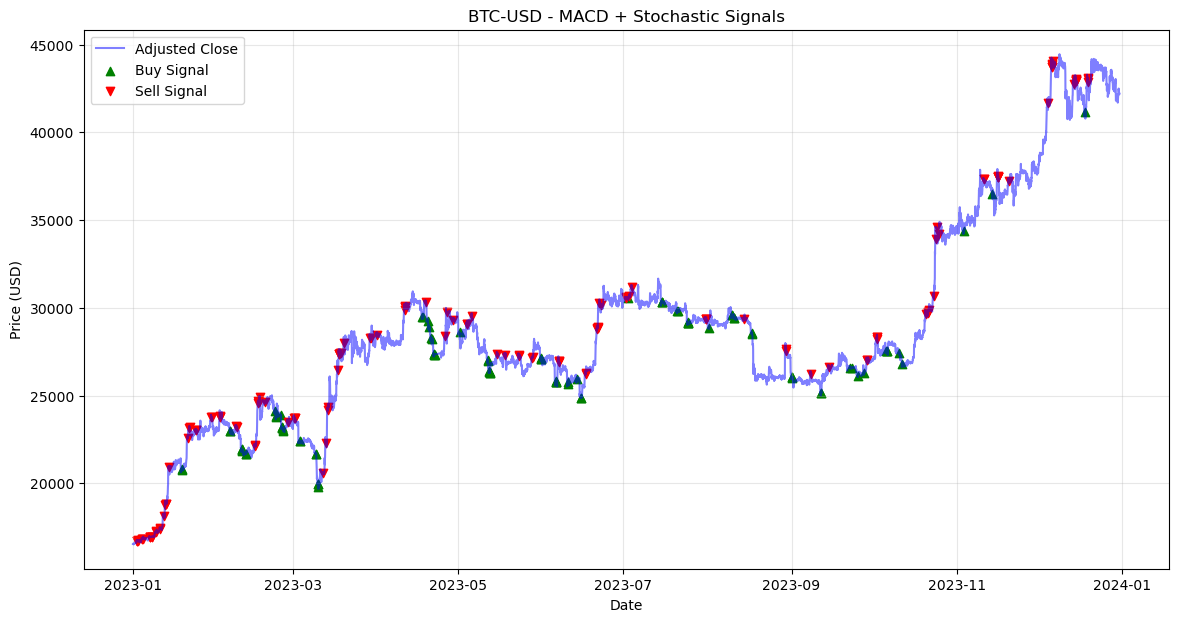

In [23]:
#bitcoin hourly for the last  year
ticker_btc = "BTC-USD"  # Bitcoin in USD
data_btc = download_data(ticker_btc, "2023-01-01", "2023-12-31", "1h")
data_btc_changed = macd_stoch_signals(calculate_stochastic(calculate_macd(data_btc), 40, 60))
plot_strategy(data_btc_changed, ticker_btc)

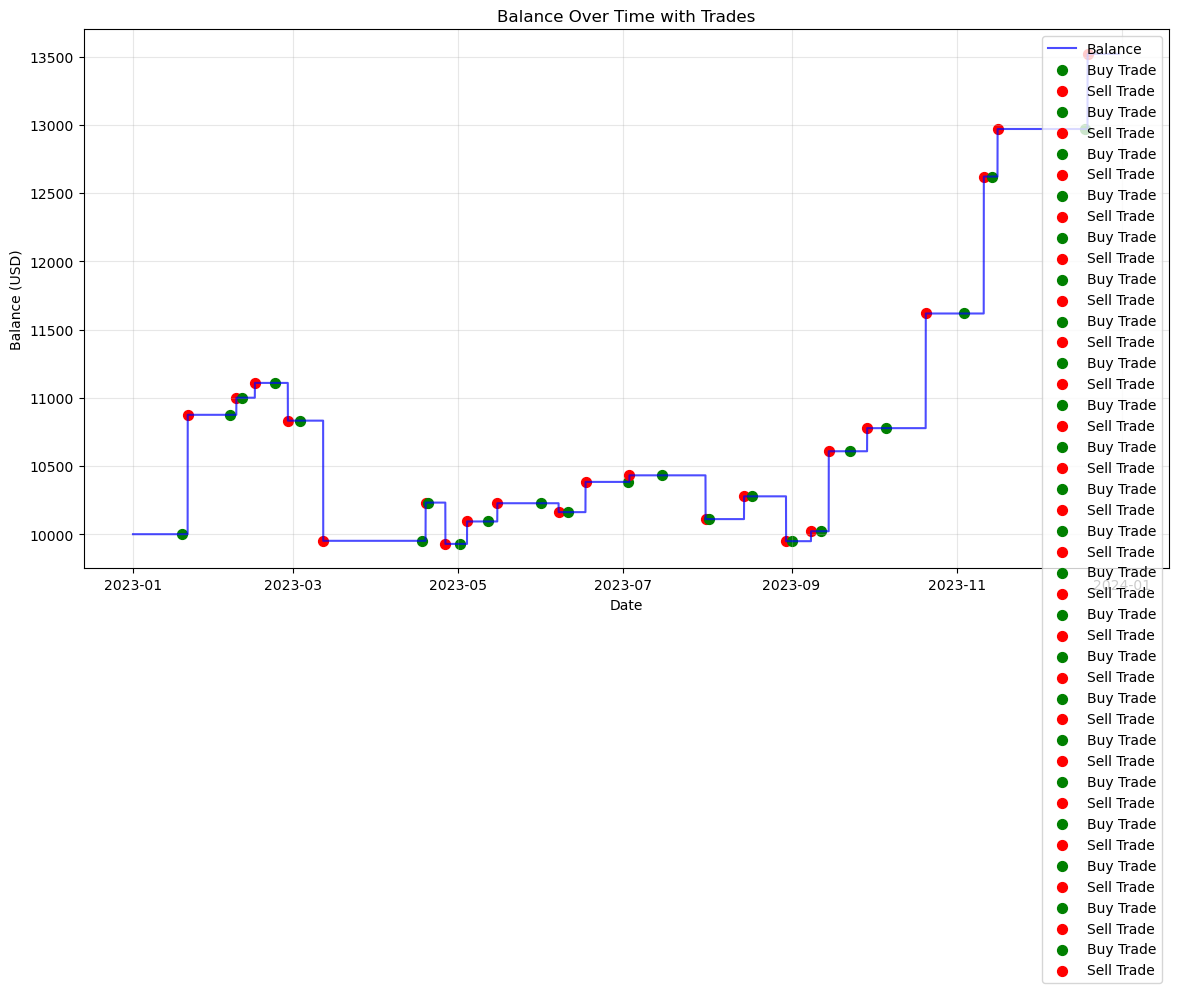

In [24]:
balance_btc, trades_btc, trades_ix_btc = backtest_single_position(data_btc_changed)
plot_balance(data_btc_changed, balance_btc, trades_ix_btc)

In [25]:
evaluation_btc = evaluate_strategy_single_position(balance_btc, trades_btc)
evaluation_btc["type"] = "Bitcoin"
results = pd.concat([results, pd.DataFrame([evaluation_btc])], ignore_index=True)
results

,Total Return (%),Win Rate (%),Profit Factor,Max Drawdown (%),Sharpe Ratio,type
0,859.221764,83.333333,7.823129,21.627262,2.539765,Stock TSLA
1,0.000000,0.000000,0.000000,0.000000,0.000000,Gold
2,0.382428,63.157895,1.473172,0.481731,0.573763,Euro to PLN
3,35.197346,72.727273,2.618718,10.619304,1.737048,Bitcoin


In [26]:
results

,Total Return (%),Win Rate (%),Profit Factor,Max Drawdown (%),Sharpe Ratio,type
0,859.221764,83.333333,7.823129,21.627262,2.539765,Stock TSLA
1,0.000000,0.000000,0.000000,0.000000,0.000000,Gold
2,0.382428,63.157895,1.473172,0.481731,0.573763,Euro to PLN
3,35.197346,72.727273,2.618718,10.619304,1.737048,Bitcoin


[*********************100%***********************]  1 of 1 completed


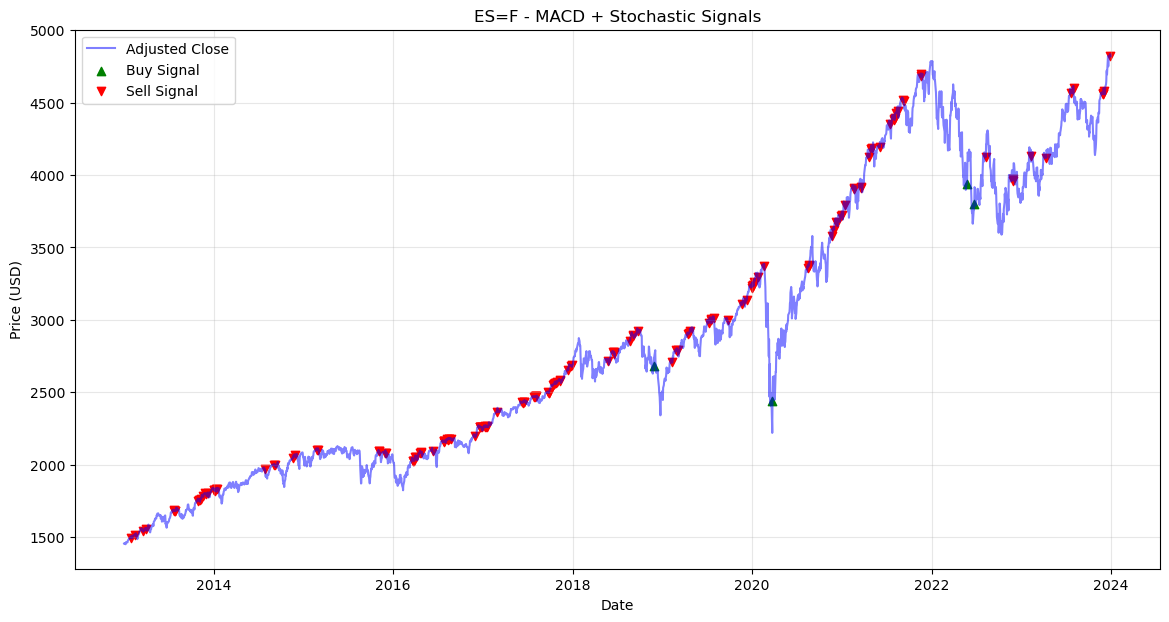

In [27]:
#sp500 ticker daily for last 10 years

ticker_sp500 = "ES=F"  # S&P 500 Futures
data_sp500 = download_data(ticker_sp500, start="2013-01-01", end="2023-12-31", interval="1d")
data_sp500_changed = macd_stoch_signals(calculate_stochastic(calculate_macd(data_sp500), 40, 60))
plot_strategy(data_sp500_changed, ticker_sp500)

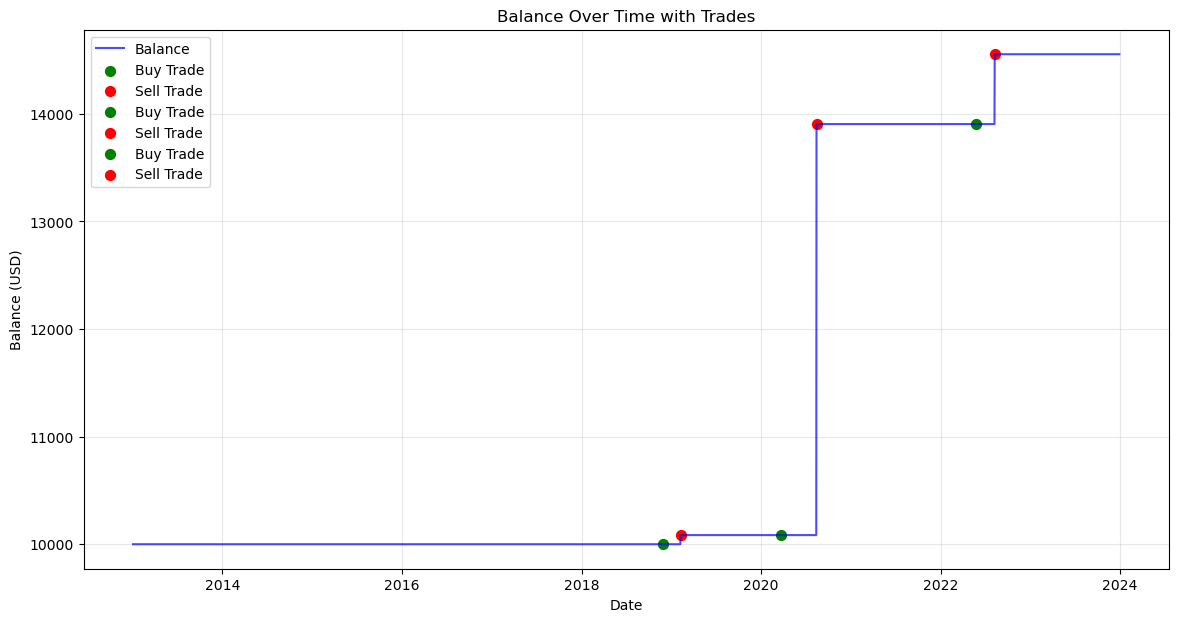

In [28]:
balance_sp500, trades_sp500, trades_ix_sp500 = backtest_single_position(data_sp500_changed)
plot_balance(data_sp500_changed, balance_sp500, trades_ix_sp500)

In [29]:
evaluation_sp500 = evaluate_strategy_single_position(balance_sp500, trades_sp500)
evaluation_sp500["type"] = "S&P 500 Futures"  # Add type for identification
results = pd.concat([results, pd.DataFrame([evaluation_sp500])], ignore_index=True)

profit is inifite for sp 500 bcs 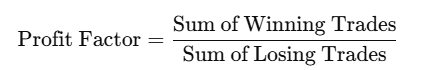 , if all trades are winning then we have 0 in denominator and it looks like inifinity 

In [30]:
results

,Total Return (%),Win Rate (%),Profit Factor,Max Drawdown (%),Sharpe Ratio,type
0,859.221764,83.333333,7.823129,21.627262,2.539765,Stock TSLA
1,0.000000,0.000000,0.0,0.000000,0.000000,Gold
2,0.382428,63.157895,1.473172,0.481731,0.573763,Euro to PLN
3,35.197346,72.727273,2.618718,10.619304,1.737048,Bitcoin
4,45.541117,100.000000,All Profitable,0.000000,1.599337,S&P 500 Futures
